## Введение. Постановка целей и задач.

COVID-19 - это вызывающий заболевание штамм коронавируса, появившийся в декабре 2019 года и приведший к продолжающейся глобальной пандемии. Возможность предвидеть путь пандемии имеет решающее значение. Это важно для того, чтобы определить, как бороться, и отследить его распространение.
Данное исследование было проведено на основе данных по Бразилии, как одной из наиболее пострадавших от вируса стран мира.

Цель: проведение исследования данных и построение прогноза развития пандемии COVID19 в Бразилии.

Задачи:

*   провести анализ данных о распространении COVID19 в Бразилии;
*   выявить взаимосвязи между ключевыми событиями в данных в Бразилии;
*   построить прогноз распространения пандемии COVID19 в Бразилии.

## Импорт библиотек, ознакомление с данными.

### Импорт Датафрейма, библиотек, написание функций.

In [ ]:
# загружаем pmdarima
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.3 MB/s 
     |████████████████████████████████| 9.8 MB 40.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
# загружаем fbprophet
!pip install fbprophet

In [ ]:
# импортируем стандартные библиотеки
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
# импорт моделей 
from statsmodels.tsa.statespace.sarimax import SARIMAX       # для модели SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose      # для ETS графиков
from pmdarima import auto_arima                              # для поиска ARIMA моделей (подбирает оптимальные параметры для модели)
from fbprophet import Prophet                                # для модели Prophet
from statsmodels.tsa.holtwinters import SimpleExpSmoothing 
from statsmodels.tsa.holtwinters import ExponentialSmoothing # для модели Экспоненциальное сглаживание

# метрики
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse

In [ ]:
# импортируем данные
url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
df = pd.read_csv(url)

In [ ]:
# проверяем, что все выгрузилось корректно
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


### Знакомство с данными

In [ ]:
# смотрим общую информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157012 entries, 0 to 157011
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    157012 non-null  object 
 1   continent                                   147576 non-null  object 
 2   location                                    157012 non-null  object 
 3   date                                        157012 non-null  object 
 4   total_cases                                 154170 non-null  float64
 5   new_cases                                   154116 non-null  float64
 6   new_cases_smoothed                          152965 non-null  float64
 7   total_deaths                                136719 non-null  float64
 8   new_deaths                                  136879 non-null  float64
 9   new_deaths_smoothed                         136747 non-null  float64
 

In [ ]:
# смотрим, какие представлены страны и выбираем страну для анализа
df['location'].unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethi

Выбираем Бразилию, то есть df.location == Brazil

## Предобработка данных

### Фильтрация данных


Фильтруем данные по условию df.location == Brazil, выбирая признаки: дата (день), страна и показатели. Выбираем наиболее значимые для наших целей показатели:
 
*   new_cases - новые случаи заболеваний за день
*   new_deaths - новые случаи смертей за день
*   total_cases - накопительный итогом кол-во новых случаев заболеваний
*   total_deaths - накопительный итогом кол-во смертей
*   new_vaccinations_smoothed - введены новые дозы вакцинации против COVID-19 (7-дневные сглаженные)
*   people_vaccinated - общее число людей, получивших хотя бы одну дозу вакцины
*   stringency_index - индекс жесткости ответных мер правительства: сводный показатель, основанный на 9 показателях реагирования, включая закрытие школ, закрытие рабочих мест и запреты на поездки, измененный до значения от 0 до 100 (100 = самый строгий ответ)

In [ ]:
df_new = df[df.location == 'Brazil'][['location', 'date', 'new_cases', 'total_cases', \
                                      'new_deaths', 'total_deaths', 'new_vaccinations_smoothed',\
                                      'people_vaccinated', 'stringency_index' ]]
df_new.head() # проверяем

,location,date,new_cases,total_cases,new_deaths,total_deaths,new_vaccinations_smoothed,people_vaccinated,stringency_index
19223,Brazil,2020-02-26,1.0,1.0,NaN,NaN,NaN,NaN,5.56
19224,Brazil,2020-02-27,0.0,1.0,NaN,NaN,NaN,NaN,5.56
19225,Brazil,2020-02-28,0.0,1.0,NaN,NaN,NaN,NaN,5.56
19226,Brazil,2020-02-29,1.0,2.0,NaN,NaN,NaN,NaN,5.56
19227,Brazil,2020-03-01,0.0,2.0,NaN,NaN,NaN,NaN,5.56


### Обработка пропусков

In [ ]:
# Посмотрим, в каких колонках есть пропуски
df_check_na = df_new.isna()
for i in df_check_na.columns:
  print(f'Для признака {i} пропуски:', df_check_na[i].unique())


Для признака location пропуски: [False]
Для признака date пропуски: [False]
Для признака new_cases пропуски: [False  True]
Для признака total_cases пропуски: [False]
Для признака new_deaths пропуски: [ True False]
Для признака total_deaths пропуски: [ True False]
Для признака new_vaccinations_smoothed пропуски: [ True False]
Для признака people_vaccinated пропуски: [ True False]
Для признака stringency_index пропуски: [False  True]


In [ ]:
# NaN значения нельзя просто удалить, т.к. это нарушит временной ряд. 
# Так как пропуски возникают из-за недоступности данных на определенный день, можно считать в такие дни, что показатель = 0.
df_new = df_new.fillna(0)

### Типизация данных

In [ ]:
# проверим типы данных
df_new.dtypes

location                      object
date                          object
new_cases                    float64
total_cases                  float64
new_deaths                   float64
total_deaths                 float64
new_vaccinations_smoothed    float64
people_vaccinated            float64
stringency_index             float64
dtype: object

Необходимо для location и date поменять тип данных для корректного считывания и отображения

In [ ]:
df_new['location'] = df_new['location'].astype('string')
df_new['date'] = pd.to_datetime(df_new['date'])

In [ ]:
# проверим
df_new.dtypes

location                             string
date                         datetime64[ns]
new_cases                           float64
total_cases                         float64
new_deaths                          float64
total_deaths                        float64
new_vaccinations_smoothed           float64
people_vaccinated                   float64
stringency_index                    float64
dtype: object

### Вывод по этапу

Изначальные данные представляют собой огромный массив данных, в котором заложена статистика COVID-19 по всем странам мира с большим числом показателей (67). Мы произвели фильтрацию данных. Т.к. для нашего исследования мы выбрали Бразилию, то информация по другим странам нам не нужна. Также мы оставили для исследования всего несколько показателей:
location, date, new_cases, total_cases, new_deaths, total_deaths, new_vaccinations_smoothed, people_vaccinated, stringency_index. Обработали пропуски, заменили их на нулевые значения, чтобы не искажать временной ряд. Произвели замену типов для дальнейшей корректной работы с данными.                 






## EDA (exploratory data analysis) или разведочный анализ данных.

Цель данного блока: познакомиться "поближе" с данными, которыми мы располагаем.

Задачи данного блока:

*   Сделать столбец с датами индексом;
*   Вывести статистику по нужным столбцам;
*   Построить графическое отображение столбцов;
*   Выявить связи между признаками (почему заболеваемость может расти или падать и тп).





In [ ]:
# создадим новый столбец с датами в качестве индексов
df_new.index = df_new.date

In [ ]:
# смотрим размер выборки
len(df_new)

668

In [ ]:
# входная выборка для анализа
df_new.head()

,location,date,new_cases,total_cases,new_deaths,total_deaths,new_vaccinations_smoothed,people_vaccinated,stringency_index
date,,,,,,,,,
2020-02-26,Brazil,2020-02-26,1.0,1.0,0.0,0.0,0.0,0.0,5.56
2020-02-27,Brazil,2020-02-27,0.0,1.0,0.0,0.0,0.0,0.0,5.56
2020-02-28,Brazil,2020-02-28,0.0,1.0,0.0,0.0,0.0,0.0,5.56
2020-02-29,Brazil,2020-02-29,1.0,2.0,0.0,0.0,0.0,0.0,5.56
2020-03-01,Brazil,2020-03-01,0.0,2.0,0.0,0.0,0.0,0.0,5.56


In [ ]:
# посмотрим основные статистические метрики
df_new.describe()

,new_cases,total_cases,new_deaths,total_deaths,new_vaccinations_smoothed,people_vaccinated,stringency_index
count,668.000000,6.680000e+02,668.000000,668.000000,6.680000e+02,6.680000e+02,668.000000
mean,33098.420659,1.039659e+07,926.130240,287950.881737,4.881963e+05,4.192057e+07,62.089371
std,24679.725964,8.005942e+06,784.978787,219933.718439,5.869368e+05,6.013806e+07,15.735479
min,-19796.000000,1.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,13155.500000,3.105523e+06,352.500000,102910.500000,0.000000e+00,0.000000e+00,56.710000
50%,29295.000000,8.865599e+06,740.500000,217527.000000,9.397850e+04,5.967550e+04,64.350000
75%,48746.250000,1.907948e+07,1220.500000,533334.250000,9.487798e+05,8.016484e+07,72.690000
max,124248.000000,2.223462e+07,4148.000000,618655.000000,1.941268e+06,1.658943e+08,81.020000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4b851e1cd0>,
      dtype=object)

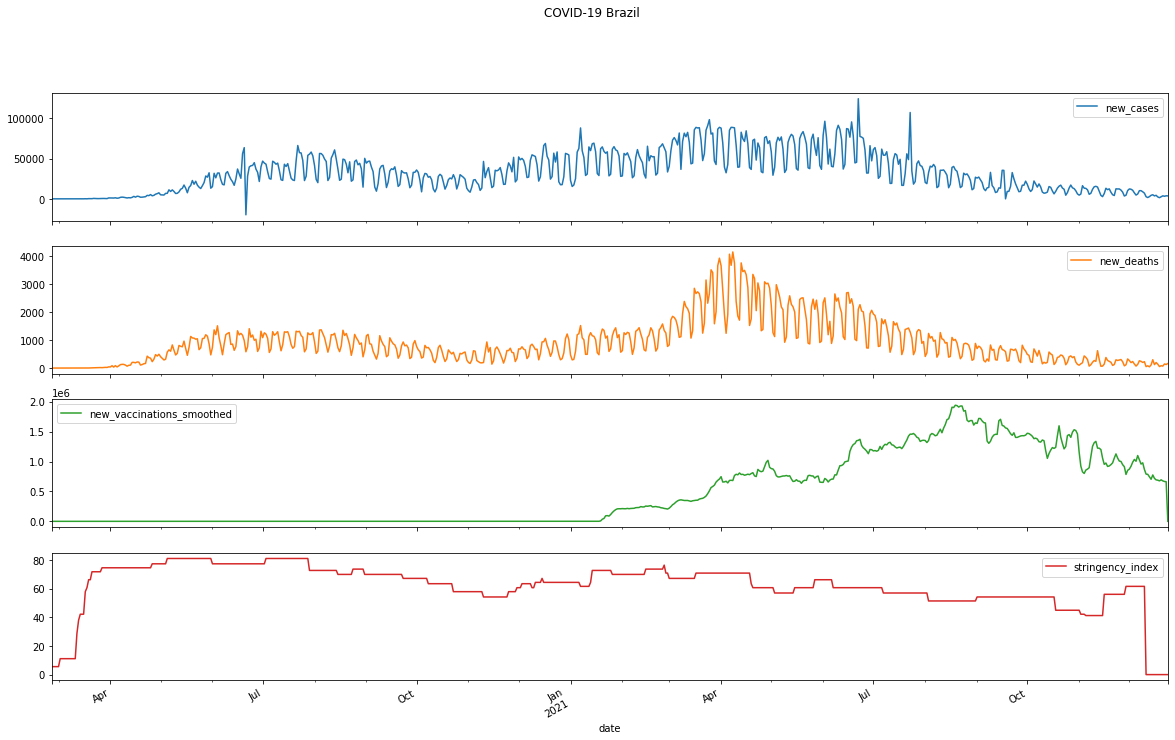

In [ ]:
# построим общий график для метрик
df_new[['new_cases', 'new_deaths', \
        'new_vaccinations_smoothed', 'stringency_index']] \
        .plot(subplots = True, figsize = (20,12), title = 'COVID-19 Brazil' )

Промежуточный вывод.
Выявлено 4 "волны" заболеваемости, наибольший масштаб в период с марта по июль 2021. Пик смертности пришелся на апрель 2021, однако далее видно резкое снижение смертности.
Бразилия начала прививать свое население в январе 2021. Высокая скорость и широкий охват вакцинации (максимальное кол-во привитых человек - 165.554.600 чел) позволили значительно снизить темпы роста заболевания и смертности с июля 2021.
Обращаясь к данным медицинской статистики, самые высокие уровни заболеваемости отмечаются в осенне-зимние периоды. Однако, с сентября 2021 по сегодняшний день (22.12.21) уровень заболеваемости только снижается (в отличие от периода сентябрь-декабрь 2020 г.). Что предварительно говорит о эффективности вакцинации.
Предварительно не выявлено взаимосвязи между заболеваемостью и строгостью ограничений в стране, несмотря на то, что уровень ограничений высок.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4b83c42090>,
      dtype=object)

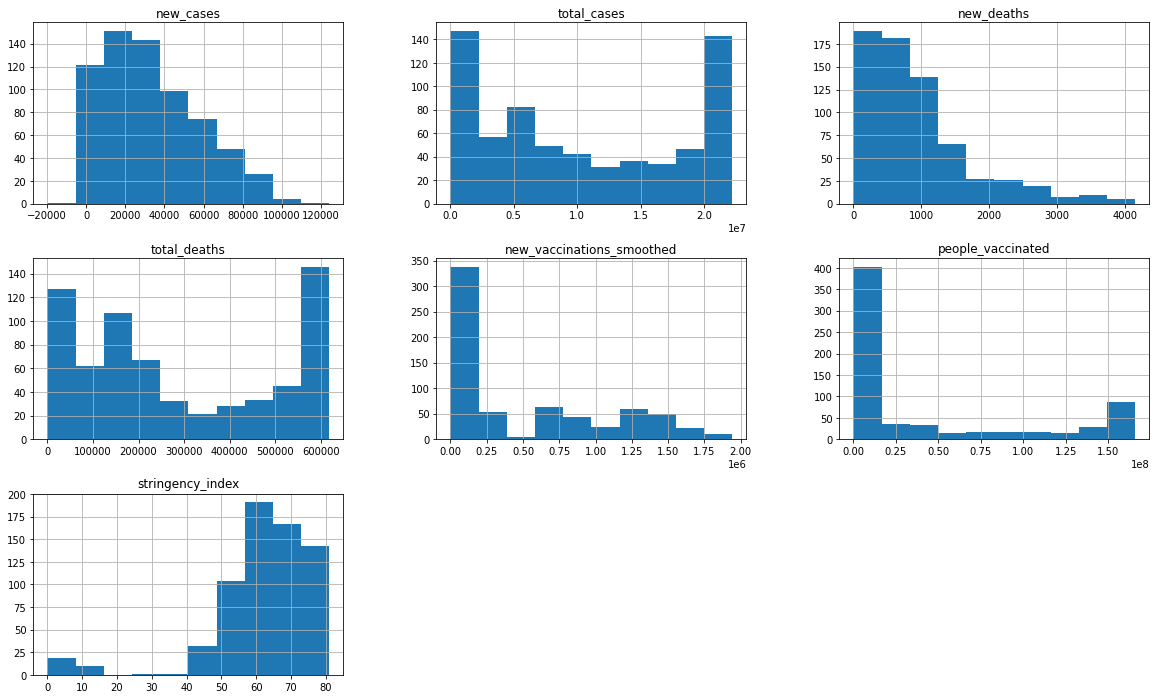

In [ ]:
# Построим гистограмму для определения распределения данных
df_new.hist(figsize = (20,12))

Промежуточный вывод:

Анализ представленных графиков позволяет сделать вывод о стабильно высоком уровне новых случаев заболевания (распределение близко к нормальному), при двух четко выраженных пиках смертности. Также можно сделать вывод о стабильно высоком уровне ограничительных антиковидных мер.



In [ ]:
# Построим матрицу корреляции признаков
df_new.corr()

,new_cases,total_cases,new_deaths,total_deaths,new_vaccinations_smoothed,people_vaccinated,stringency_index
new_cases,1.000000,0.115703,0.876102,0.090734,0.037411,-0.228809,0.284942
total_cases,0.115703,1.000000,0.139974,0.997645,0.908084,0.870511,-0.471743
new_deaths,0.876102,0.139974,1.000000,0.119117,0.125481,-0.168711,0.283192
total_deaths,0.090734,0.997645,0.119117,1.000000,0.916499,0.886371,-0.476176
new_vaccinations_smoothed,0.037411,0.908084,0.125481,0.916499,1.000000,0.870553,-0.385468
people_vaccinated,-0.228809,0.870511,-0.168711,0.886371,0.870553,1.000000,-0.486025
stringency_index,0.284942,-0.471743,0.283192,-0.476176,-0.385468,-0.486025,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

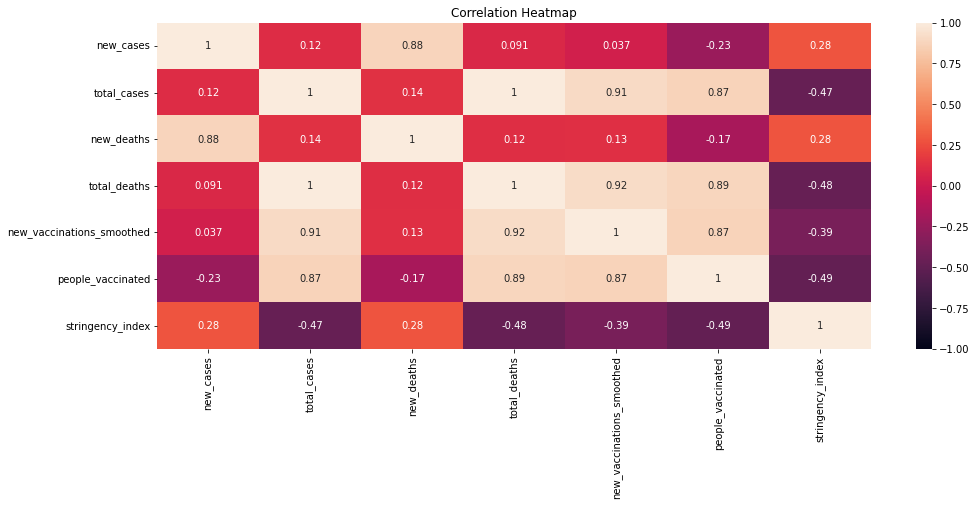

In [ ]:
# Для большей наглядности построим тепловую карту 
heatmap = plt.figure(figsize=(16, 6)) 
heatmap = sns.heatmap(df_new.corr(), vmin=-1, vmax=1, annot=True)   # задаем диапазон значений для отображения на цветовой карте \
                                                                    # от -1 до 1 и устанавливаем annot = True, \
                                                                    # чтобы отобразить числовые значения корреляции на тепловой карте.   
heatmap.set_title('Correlation Heatmap') 

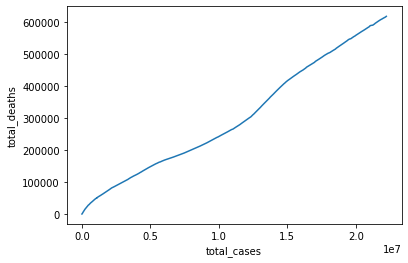

In [ ]:
# построим график зависимости total_cases от total_deaths
sns.lineplot(data = df_new, x = 'total_cases', y = 'total_deaths')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



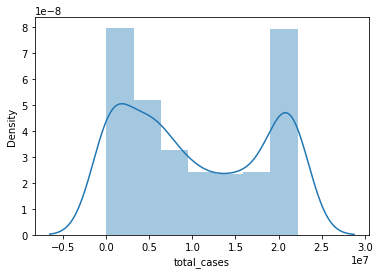

In [ ]:
# график плотности распределения total_cases
sns.distplot(df_new.total_cases)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



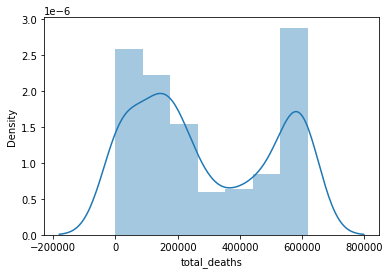

In [ ]:
# график плотности распределения total_deaths
sns.distplot(df_new.total_deaths)

Промежуточный вывод:

Имеется значимая положительная корреляции между кол-вом заболеваний и смертей (линия практически прямая), что свидетельствует о воздействии сходных факторов на уровень заболеваемости и общей смертности.

Также на графиках KDE видим, что графики распределения подобны, благодаря этому наблюдению можно сформулировать гипотезу исследования:

Если общее количество смертельных случаев выходит на плато, связано ли это со снижением новых случаев заражения?

Для этого построим прогнозную модель расчёта новых случаев заражения.

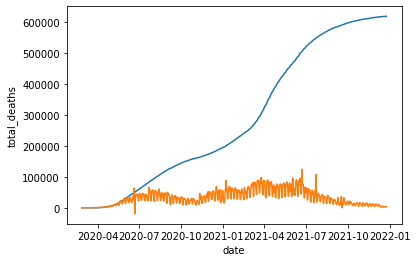

In [ ]:
# при снижении новых случаев заболеваний кол-во смертей выходит на плато
sns.lineplot(data = df_new, x = 'date', y = 'total_deaths')
sns.lineplot(data = df_new, x = 'date', y = 'new_cases')


## Построение моделей. Анализ результатов.

### Обучающая/контрольная выборки.

In [ ]:
# Выделяем выборки, где тестовая размера 10 дней
train = df_new.iloc[:len(df_new)-10]
test = df_new.iloc[len(df_new)-10:]

In [ ]:
# Посмотрим на обучающую выборку
train.head()

,location,date,new_cases,total_cases,new_deaths,total_deaths,new_vaccinations_smoothed,people_vaccinated,stringency_index
date,,,,,,,,,
2020-02-26,Brazil,2020-02-26,1.0,1.0,0.0,0.0,0.0,0.0,5.56
2020-02-27,Brazil,2020-02-27,0.0,1.0,0.0,0.0,0.0,0.0,5.56
2020-02-28,Brazil,2020-02-28,0.0,1.0,0.0,0.0,0.0,0.0,5.56
2020-02-29,Brazil,2020-02-29,1.0,2.0,0.0,0.0,0.0,0.0,5.56
2020-03-01,Brazil,2020-03-01,0.0,2.0,0.0,0.0,0.0,0.0,5.56


In [ ]:
# Посмотрим на тестовую выборку
test.head()

,location,date,new_cases,total_cases,new_deaths,total_deaths,new_vaccinations_smoothed,people_vaccinated,stringency_index
date,,,,,,,,,
2021-12-15,Brazil,2021-12-15,5078.0,22205707.0,298.0,617552.0,775439.0,165135181.0,0.0
2021-12-16,Brazil,2021-12-16,3661.0,22209368.0,123.0,617675.0,718834.0,165279022.0,0.0
2021-12-17,Brazil,2021-12-17,4363.0,22213731.0,198.0,617873.0,692922.0,165393977.0,0.0
2021-12-18,Brazil,2021-12-18,2381.0,22216112.0,138.0,618011.0,688367.0,165409165.0,0.0
2021-12-19,Brazil,2021-12-19,1458.0,22217570.0,55.0,618066.0,676319.0,165417886.0,0.0


### ETS декомпозиция

In [ ]:
r = seasonal_decompose(df_new['new_cases'], model = 'additive')

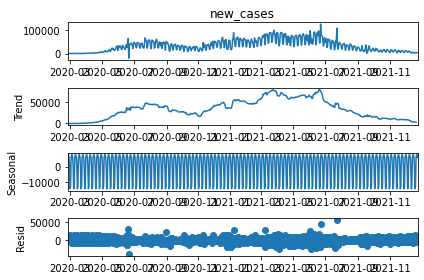

In [ ]:
r.plot();

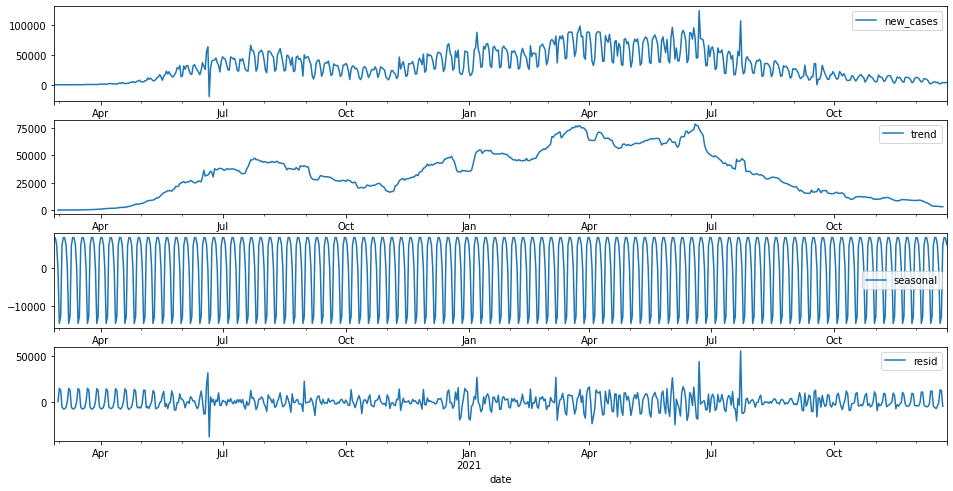

In [ ]:
# seasonal_decompose в увеличенном виде
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(16,8))
r.observed.plot(ax=ax1, legend=True)
r.trend.plot(ax=ax2, legend=True)
r.seasonal.plot(ax=ax3, legend=True)
r.resid.plot(ax=ax4, legend=True)

Промежуточный вывод:

На графике наблюдаем недельную сезонность.

### Построение моделей

---
Задачи:
- описать модель
- подобрать оптимальные параметры
- создать модель
- обучить модель
- сделать прогноз на период тестовой выборки
- сравнить прогноз с тестовой выборкой (построить график)
- оценить качество прогноза
- сделать прогноз на 10-15 дней на будущее
- сделать выводы о работе данного метода прогнозирования

---

### 1-й метод прогнозирования - SARIMAX

#### Описание модели SARIMAX

SARIMAX - модель сезонной авторегрессии с интегрированным скользящим средним. 

Это модель временных рядов, построенная на основе расширенной (eXtended) модели ARIMA с добавлением сезонности (Seasonal).

ARIMA (англ. autoregressive integrated moving average)- интегрированная модель авторегрессии — скользящего среднего.

Процесс авторегрессии — последовательная зависимость элементов временного ряда.

Процесс скользящего среднего — в процессе скользящего среднего каждый элемент ряда подвержен суммарному воздействию предыдущих ошибок.

Таким образом, SARIMA учитывает сезонность, добавляя линейную комбинацию прошлых сезонных значений и/или прошлых ошибок прогноза. 

In [ ]:
# Запустим pmdarima.auto_arima чтобы получить набор параметров для нашей модели
auto_arima(df_new['new_cases'],seasonal=True, m=7).summary() #включаем сезонность и указываем период сезонности = 1 неделя

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  668
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 7)   Log Likelihood               -6978.870
Date:                           Sat, 25 Dec 2021   AIC                          13975.740
Time:                                   07:44:06   BIC                          14016.265
Sample:                                        0   HQIC                         13991.440
                                           - 668                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0604      0.887     -0.068      0.946      -1.798       1.677
ar.L2         -0.0174      0.184     -0.095      0.925      -0.378       0.343
ma.L1         -0.6088      0.881     -0.691      0.489      -2.335       1.117
ma.L2         -0.1909      0.757     -0.252      0.801      -1.674       1.292
ar.S.L7        0.3426      0.231      1.482      0.138      -0.110       0.796
ar.S.L14       0.6178      0.223      2.767      0.006       0.180       1.055
ma.S.L7       -0.0485      0.226     -0.215      0.830      -0.491       0.394
ma.S.L14      -0.5637      0.156     -3.618      0.000      -0.869      -0.258
sigma2      8.968e+07   1.93e-07   4.64e+14      0.000    8.97e+07    8.97e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3492.74
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.60   Skew:                             0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.19e+29. Standard errors may be unstable.
"""

Промежуточный вывод:

Получилась модель с параметрами SARIMAX(2, 1, 2)x(2, 0, 2, 7)

In [ ]:
# создаем модель с подобранными параметрами
model_sarimax = SARIMAX(train['new_cases'],order=(2, 1, 2), seasonal_order=(2, 0, 2, 7))

#обучаем модель на обучающей выборке данных
results_sarimax = model_sarimax.fit()

#получаем результаты
results_sarimax.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         new_cases   No. Observations:                  658
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 7)   Log Likelihood               -6879.003
Date:                           Sat, 25 Dec 2021   AIC                          13776.006
Time:                                   07:44:10   BIC                          13816.395
Sample:                               02-26-2020   HQIC                         13791.664
                                    - 12-14-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0624      0.896     -0.070      0.944      -1.819       1.694
ar.L2         -0.0176      0.186     -0.095      0.924      -0.381       0.346
ma.L1         -0.6074      0.890     -0.682      0.495      -2.352       1.137
ma.L2         -0.1918      0.765     -0.251      0.802      -1.691       1.307
ar.S.L7        0.3425      0.234      1.464      0.143      -0.116       0.801
ar.S.L14       0.6183      0.226      2.735      0.006       0.175       1.061
ma.S.L7       -0.0491      0.228     -0.215      0.830      -0.497       0.398
ma.S.L14      -0.5649      0.158     -3.576      0.000      -0.874      -0.255
sigma2      9.103e+07   1.92e-07   4.74e+14      0.000     9.1e+07     9.1e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3322.71
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.63   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.78e+29. Standard errors may be unstable.
"""

In [ ]:
#предсказываем значения,передав модели results точку начала и окончания
prediction_sarimax = results_sarimax.predict(start=len(train), \
                    end=len(train)+len(test)-1, dynamic=False, typ='levels') \
                    .rename(' Predictions SARIMAX(2, 1, 2)x(2, 0, 2, 7)	')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 9 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 9 missing from current font.



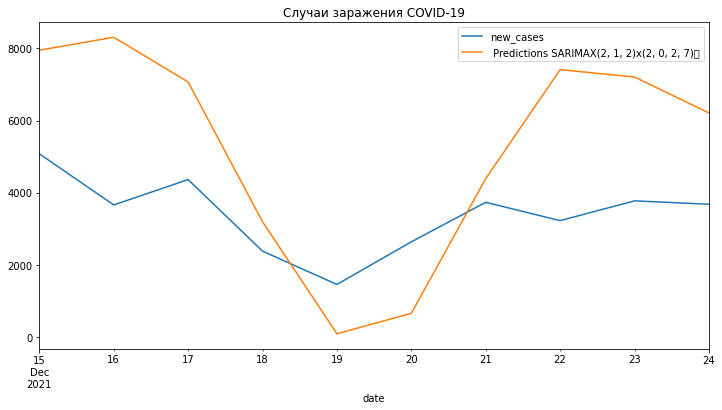

In [ ]:
#сравниваем прогноз и тестовую выборку
ax = test['new_cases'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19')
prediction_sarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [ ]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE
mae_error = mean_absolute_error(test['new_cases'], prediction_sarimax)
mse_error = mean_squared_error(test['new_cases'], prediction_sarimax)
rmse_error = rmse(test['new_cases'], prediction_sarimax)
mape_error = np.mean(np.abs(prediction_sarimax - test['new_cases'])/test['new_cases'])*100

print(f'SARIMAX(2, 1, 2)x(2, 0, 2, 7) MAE Error: {mae_error:11.10}')
print(f'SARIMAX(2, 1, 2)x(2, 0, 2, 7) MSE Error: {mse_error:11.10}')
print(f'SARIMAX(2, 1, 2)x(2, 0, 2, 7) RMSE Error: {rmse_error:11.10}')
print(f'SARIMAX(2, 1, 2)x(2, 0, 2, 7) MAPE Error: {mape_error:11.10}')

SARIMAX(2, 1, 2)x(2, 0, 2, 7) MAE Error: 2518.316787
SARIMAX(2, 1, 2)x(2, 0, 2, 7) MSE Error: 7969319.669
SARIMAX(2, 1, 2)x(2, 0, 2, 7) RMSE Error: 2822.998347
SARIMAX(2, 1, 2)x(2, 0, 2, 7) MAPE Error: 75.53439027


In [ ]:
#делаем прогноз на будущее - 10 дней вперед

# обучаем модель на всем датасете
fut_model_sarimax = SARIMAX(df_new['new_cases'],order=(2, 1, 2), seasonal_order=(2, 0, 2, 7))
fut_results_sarimax = fut_model_sarimax.fit()
fut_results_sarimax.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         new_cases   No. Observations:                  668
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 7)   Log Likelihood               -6978.870
Date:                           Sat, 25 Dec 2021   AIC                          13975.740
Time:                                   07:44:14   BIC                          14016.265
Sample:                               02-26-2020   HQIC                         13991.440
                                    - 12-24-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0604      0.887     -0.068      0.946      -1.798       1.677
ar.L2         -0.0174      0.184     -0.095      0.925      -0.378       0.343
ma.L1         -0.6088      0.881     -0.691      0.489      -2.335       1.117
ma.L2         -0.1909      0.757     -0.252      0.801      -1.674       1.292
ar.S.L7        0.3426      0.231      1.482      0.138      -0.110       0.796
ar.S.L14       0.6178      0.223      2.767      0.006       0.180       1.055
ma.S.L7       -0.0485      0.226     -0.215      0.830      -0.491       0.394
ma.S.L14      -0.5637      0.156     -3.618      0.000      -0.869      -0.258
sigma2      8.968e+07   1.93e-07   4.64e+14      0.000    8.97e+07    8.97e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3492.74
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.60   Skew:                             0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.19e+29. Standard errors may be unstable.
"""

In [ ]:
#задаем точки будущего
fut_fcast_sarimax = fut_results_sarimax.predict(len(df_new)-1,len(df_new)+9,typ='levels') \
                    .rename('SARIMAX(2, 1, 2)x(2, 0, 2, 7) Forecast')

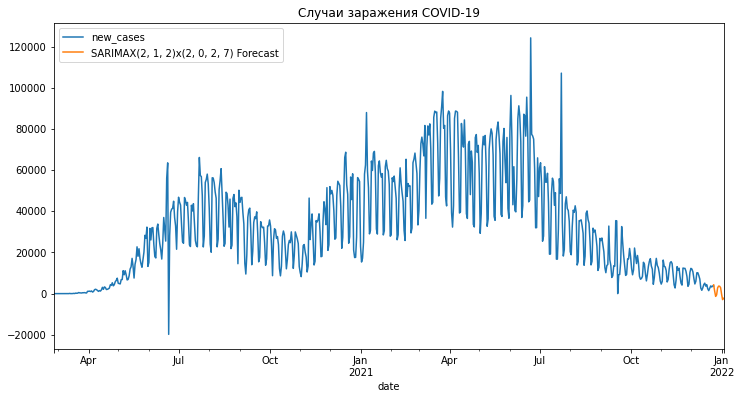

In [ ]:
#строим график на будущее
ax = df_new['new_cases'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19') 
fut_fcast_sarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)

#### Выводы работы метода SARIMAX


Видим, что модель SARIMAX сработала с большой неточностью. Средняя абсолютная ошибка (МАЕ) - 2518, средняя абсолютная ошибка в процентах (МАРЕ) - 75.5.

### 2-й метод прогнозирования - PROPHET

#### Описание метода PROPHET

Prophet - это процедура для прогнозирования данных временных рядов на основе аддитивной модели, в которой нелинейные тенденции корректируются с учетом годовой, еженедельной и ежедневной сезонности в дополнение к эффектам праздников. Лучше всего работает с временными рядами с сильными сезонными эффектами и несколькими сезонами исторических данных. Prophet устойчив к отсутствующим данным и изменениям в тенденциях и обычно хорошо справляется с выбросами. 

In [ ]:
# подготовим данные для модели
train_prophet = train[['date', 'new_cases']]
test_prophet = test[['date', 'new_cases']]

In [ ]:
# переименуем столбцы в тестовом и обучающем датасетах, чтобы они подходили для использования метода Prophet
train_prophet.columns = ['ds', 'y']
test_prophet.columns = ['ds', 'y']

In [ ]:
# подготовим данные по всему датасету для модели
df_new_prophet = df_new[['date', 'new_cases']]
df_new_prophet.columns = ['ds', 'y']   # переименовали столбцы

In [ ]:
# создаем модель с подобранными параметрами
model_prophet = Prophet(seasonality_mode = 'multiplicative')  

In [ ]:
# обучаем модель на обучающей выборке данных
model_prophet.fit(train_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Промежуточные выводы:

Алгоритм проигнорировал:

*   годовую сезонность (для годовой сезонности нам нужно иметь данные минимум за 2 года, чтобы суметь использовать ее в модели)
*   дневную сезонность (дневная сезонность может использоваться в случае, если данные собираются по часам/минутам, в нашем случае данные представлены по месяцам).

Зато он обнаружил недельную сезонность и использовал его при настройке модели.

In [ ]:
# говорим prophet сделать датафрейм на 10 дней вперед
future_prophet = model_prophet.make_future_dataframe(periods = 10)

In [ ]:
# предсказываем значения по модели
prediction_prophet = model_prophet.predict(future_prophet)
prediction_prophet.head()   # получаем много колонок. Нас интересует yhat

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2020-02-26,-5782.733596,-18711.218025,5219.299272,-5782.733596,-5782.733596,0.238002,0.238002,0.238002,0.238002,0.238002,0.238002,0.0,0.0,0.0,-7159.037001
1,2020-02-27,-5498.976368,-19458.043516,5458.373775,-5498.976368,-5498.976368,0.225380,0.225380,0.225380,0.225380,0.225380,0.225380,0.0,0.0,0.0,-6738.334213
2,2020-02-28,-5215.219141,-17886.321967,5397.512970,-5215.219141,-5215.219141,0.173456,0.173456,0.173456,0.173456,0.173456,0.173456,0.0,0.0,0.0,-6119.828529
3,2020-02-29,-4931.461913,-17777.284269,7318.953493,-4931.461913,-4931.461913,0.002170,0.002170,0.002170,0.002170,0.002170,0.002170,0.0,0.0,0.0,-4942.162924
4,2020-03-01,-4647.704685,-14818.547508,9078.988657,-4647.704685,-4647.704685,-0.430716,-0.430716,-0.430716,-0.430716,-0.430716,-0.430716,0.0,0.0,0.0,-2645.863472


In [ ]:
# устанавливаем индекс
prediction_prophet.index = prediction_prophet.ds
prediction_prophet.head() # проверим изменения

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
2020-02-26,2020-02-26,-5782.733596,-18711.218025,5219.299272,-5782.733596,-5782.733596,0.238002,0.238002,0.238002,0.238002,0.238002,0.238002,0.0,0.0,0.0,-7159.037001
2020-02-27,2020-02-27,-5498.976368,-19458.043516,5458.373775,-5498.976368,-5498.976368,0.225380,0.225380,0.225380,0.225380,0.225380,0.225380,0.0,0.0,0.0,-6738.334213
2020-02-28,2020-02-28,-5215.219141,-17886.321967,5397.512970,-5215.219141,-5215.219141,0.173456,0.173456,0.173456,0.173456,0.173456,0.173456,0.0,0.0,0.0,-6119.828529
2020-02-29,2020-02-29,-4931.461913,-17777.284269,7318.953493,-4931.461913,-4931.461913,0.002170,0.002170,0.002170,0.002170,0.002170,0.002170,0.0,0.0,0.0,-4942.162924
2020-03-01,2020-03-01,-4647.704685,-14818.547508,9078.988657,-4647.704685,-4647.704685,-0.430716,-0.430716,-0.430716,-0.430716,-0.430716,-0.430716,0.0,0.0,0.0,-2645.863472


In [ ]:
# нас интересует 2 колонки: ds - дата прогноза и yhat - спрогнозированное значение. Оставим только их
prediction_prophet[['ds', 'yhat']]


,ds,yhat
ds,,
2020-02-26,2020-02-26,-7159.037001
2020-02-27,2020-02-27,-6738.334213
2020-02-28,2020-02-28,-6119.828529
2020-02-29,2020-02-29,-4942.162924
2020-03-01,2020-03-01,-2645.863472
...,...,...
2021-12-20,2021-12-20,-3049.616727
2021-12-21,2021-12-21,-6366.191668
2021-12-22,2021-12-22,-7031.942521


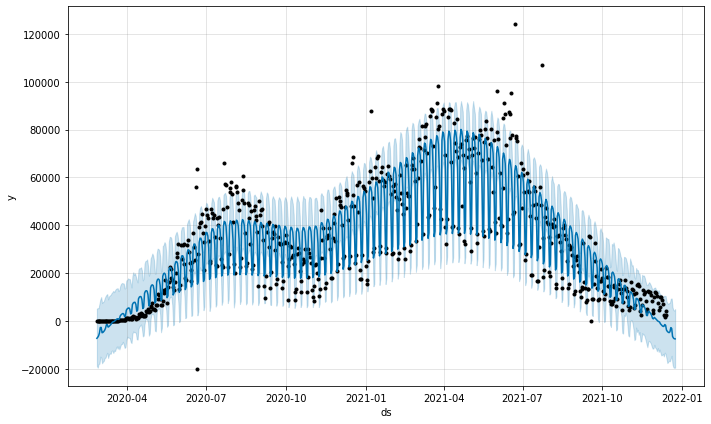

In [ ]:
# сравниваем прогноз и тестовую выборку, где черные точки - это тестовая выборка
model_prophet.plot(prediction_prophet);

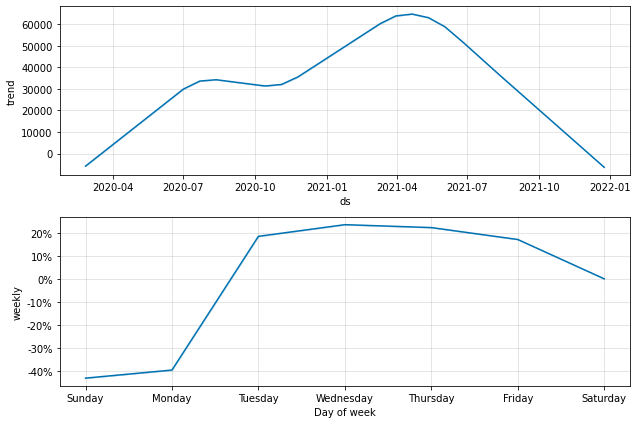

In [ ]:
# разложим ряд на основные компоненты: тренд и сезонность
model_prophet.plot_components(prediction_prophet);

In [ ]:
# оцениваем качество модели методом MSE, RMSE, MAE и MAPE
mae_error = mean_absolute_error(test_prophet['y'], prediction_prophet['yhat'].tail(10))
mse_error = mean_squared_error(test_prophet['y'], prediction_prophet['yhat'].tail(10))
rmse_error = rmse(test_prophet['y'], prediction_prophet['yhat'].tail(10))
mape_error = np.mean(np.abs(prediction_prophet['yhat'] - test_prophet['y']) / test_prophet['y']) * 100

In [ ]:
print(f'Prophet MAE Error: {mae_error:11.10}')
print(f'Prophet MSE Error: {mse_error:11.10}')
print(f'Prophet RMSE Error: {rmse_error:11.10}')
print(f'Prophet MAPE Error: {mape_error:11.10}')

Prophet MAE Error: 8601.706071
Prophet MSE Error:  78998333.1
Prophet RMSE Error: 8888.100646
Prophet MAPE Error: 259.0947223


In [ ]:
# делаем прогноз на будущее - 10 дней вперед

# обучаем модель на всем датасете
fut_model_prophet = Prophet(seasonality_mode = 'multiplicative')
fut_model_prophet.fit(df_new_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# говорим prophet сделать датафрейм на 10 дней вперед
fut_future_prophet = fut_model_prophet.make_future_dataframe(periods = 10)
fut_fcast_prophet = fut_model_prophet.predict(fut_future_prophet)

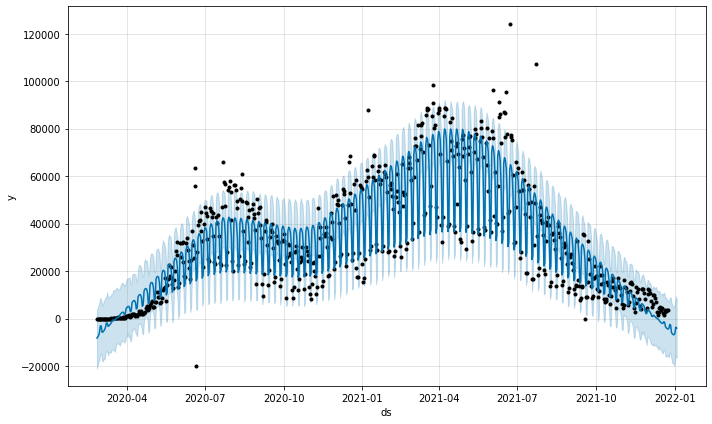

In [ ]:
#сравниваем прогноз и всю выборку, где черные точки - входная выборка
fut_model_prophet.plot(fut_fcast_prophet);

In [ ]:
# устанавливаем индекс
fut_fcast_prophet.index = fut_fcast_prophet.ds

In [ ]:
# убедимся в изменениях
fut_fcast_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
2020-02-26,2020-02-26,-6630.794473,-21055.106740,3578.342291,-6630.794473,-6630.794473,0.238174,0.238174,0.238174,0.238174,0.238174,0.238174,0.0,0.0,0.0,-8210.079258
2020-02-27,2020-02-27,-6333.067187,-19614.356972,4716.946545,-6333.067187,-6333.067187,0.225418,0.225418,0.225418,0.225418,0.225418,0.225418,0.0,0.0,0.0,-7760.657661
2020-02-28,2020-02-28,-6035.339901,-17968.063245,5768.303636,-6035.339901,-6035.339901,0.173434,0.173434,0.173434,0.173434,0.173434,0.173434,0.0,0.0,0.0,-7082.073572
2020-02-29,2020-02-29,-5737.612616,-17119.316659,7047.042037,-5737.612616,-5737.612616,0.002416,0.002416,0.002416,0.002416,0.002416,0.002416,0.0,0.0,0.0,-5751.473739
2020-03-01,2020-03-01,-5439.885330,-14653.764500,8819.519202,-5439.885330,-5439.885330,-0.431192,-0.431192,-0.431192,-0.431192,-0.431192,-0.431192,0.0,0.0,0.0,-3094.251684


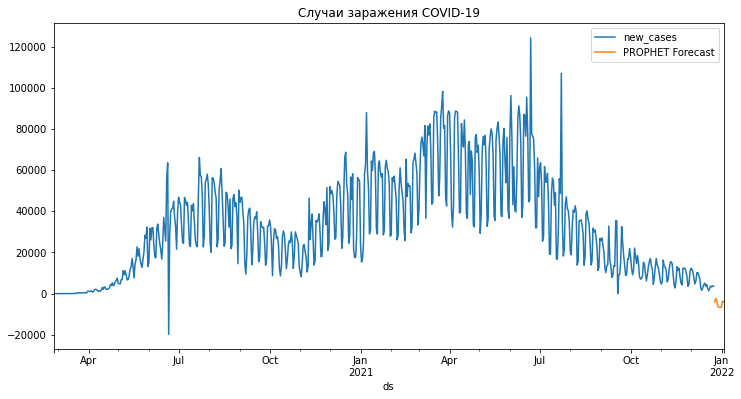

In [ ]:
#строим график на будущее
ax = df_new_prophet['y'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19') 
fut_fcast_prophet['yhat'].tail(10).plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.legend(["new_cases", "PROPHET Forecast"]);

#### Выводы работы метода PROPHET

Видим, что модель Prophet сработала еще менее точно, чем SARIMAX. Средняя абсолютная ошибка (МАЕ) - 8601, средняя абсолютная ошибка в процентах (МАРЕ) - 259.
По графику прогноза также можно сделать вывод о неточности модели.

### 3-й метод прогнозирования - модель Хольта-Винтерса

#### Описание модели Хольта-Винтерса

Метод Хольта-Винтерса (алгоритм тройного экспоненциального сглаживания) - это трехпараметрическая модель прогноза, которая учитывает:

*   сглаженный экспоненциальный ряд;
*   тренд;
*   сезонность.

Экспоненциальное сглаживание — один из наиболее успешных классических методов предсказаний. Прогнозы равны взвешенному среднему от старых наблюдений, и соответствующие веса убывают экспоненциально по мере хода времени.

Метод Хольта-Винтерса для расширения алгоритма позволяет добавить тренд и сезонность.


In [ ]:
# создаем модель с подобранными параметрами
model_hw = ExponentialSmoothing(train['new_cases'], seasonal_periods=7, trend = 'add', seasonal = 'add')   # недельная сезонность

#обучаем модель на обучающей выборке данных
model_hw.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [ ]:
start = len(train)
end = len(train)+len(test)-1
predictions_hw = model_hw.predict(model_exps.params, start=start, end=end)
predictions_hw

array([8887.40940398, 8840.4889819 , 8212.64332628, 4664.00024066,
       1178.1711591 , 1546.1306744 , 6435.69459435, 8894.26666978,
       8847.3462477 , 8219.50059208])

In [ ]:
#преобразуем в датафрейм с индексами
predictions_hw = pd.DataFrame(predictions_hw)
predictions_hw.index = pd.date_range(test.index[0], periods=10, freq="D")

predictions_hw.columns = ['predictions_hw']

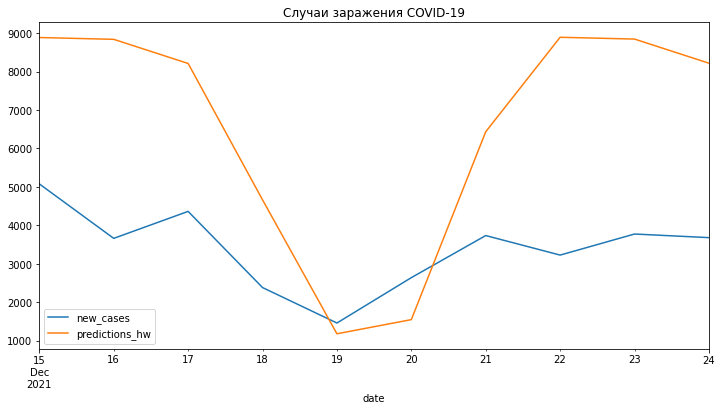

In [ ]:
#сравниваем прогноз и тестовую выборку
ax = test['new_cases'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19')
predictions_hw['predictions_hw'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

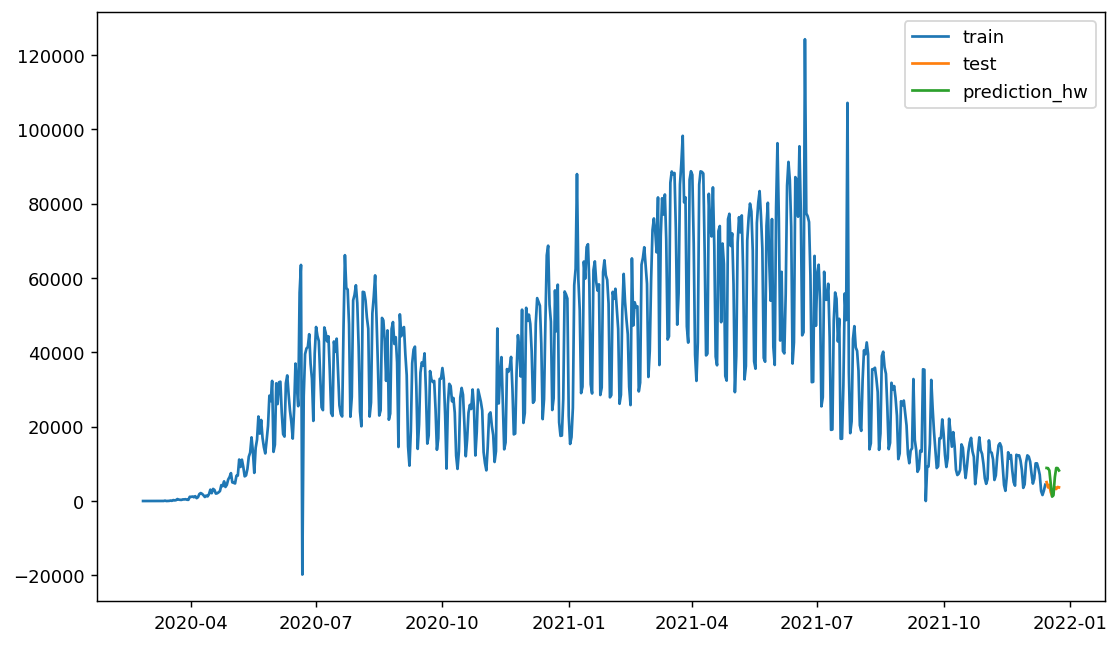

In [ ]:
plt.figure(figsize=(10,6), dpi=130)
plt.plot(train['new_cases'], label='train')
plt.plot(test['new_cases'], label='test')
plt.plot(predictions_hw, label='prediction_hw')
plt.legend()
plt.show()

In [ ]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE
mae_error = mean_absolute_error(test['new_cases'], predictions_hw['predictions_hw'])
mse_error = mean_squared_error(test['new_cases'], predictions_hw['predictions_hw'])
rmse_error = rmse(test['new_cases'], predictions_hw['predictions_hw'])
mape_error = np.mean(np.abs(predictions_hw['predictions_hw'] - test['new_cases'])/test['new_cases'])*100

print(f'Holt-Winters Model MAE Error: {mae_error:11.10}')
print(f'Holt-Winters Model MSE Error: {mse_error:11.10}')
print(f'Holt-Winters Model RMSE Error: {rmse_error:11.10}')
print(f'Holt-Winters Model MAPE Error: {mape_error:11.10}')

Holt-Winters Model MAE Error: 3447.704822
Holt-Winters Model MSE Error:  14841752.6
Holt-Winters Model RMSE Error: 3852.499526
Holt-Winters Model MAPE Error: 96.70627072


In [ ]:
#делаем прогноз на будущее - 10 дней вперед

# обучаем модель на всем датасете
fut_model_hw = ExponentialSmoothing(df_new['new_cases'], seasonal_periods=7, trend = 'add')   # недельная сезонность
fut_model_hw.fit()

#задаем точки будущего
fut_fcast_hw = fut_model_hw.predict(fut_model_hw.params, start=len(df_new)-1, end=len(df_new)+9)

#преобразуем в датафрейм с индексами
fut_fcast_hw = pd.DataFrame(fut_fcast_hw)
freq="D"
fut_fcast_hw.index = pd.date_range(test.index[-1] + pd.Timedelta(1, unit=freq), periods=11, freq="D")
fut_fcast_hw.columns = ['fut_fcast_hw']

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [ ]:
#проверим
fut_fcast_hw.head()

,fut_fcast_hw
2021-12-25,2713.217390
2021-12-26,2643.199241
2021-12-27,2454.404943
2021-12-28,2265.610644
2021-12-29,2076.816346


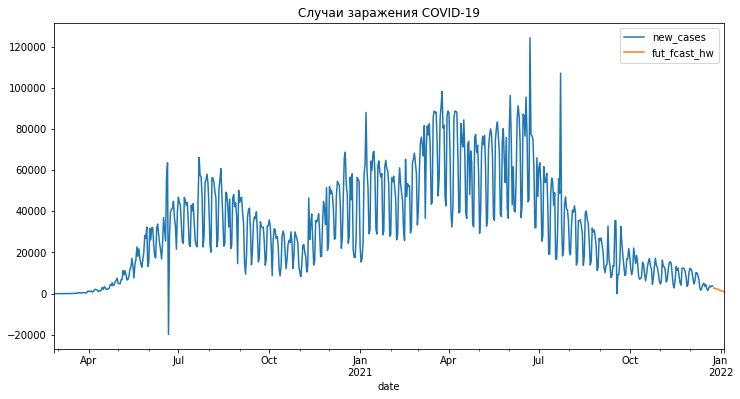

In [ ]:
#строим график на будущее
ax = df_new['new_cases'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19') 
fut_fcast_hw['fut_fcast_hw'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

#### Выводы работы метода Holt-Winters

Видим, что модель Хольта-Винтерса сработала лучше Prophet, но хуже SARIMAX. Средняя абсолютная ошибка (МАЕ) - 3447, средняя абсолютная ошибка в процентах (МАРЕ) - 96.7.

## Выводы

---
- Проведен анализ данных с использованием современных методов обработки статистической информации. 

- Рассчитаны основные статистические метрики, позволяющие судить о характере исследуемого явления.

- Результаты анализа представленных данных помогли выявить зависимость новых случаев заражения и новых смертельных случаев от одних факторов.

- Выявлено положительное влиение фактора вакцинации на снижение уровня заболеваемости и смертности.

- Прогнозные модели позволяют говорить о дальнейшем снижении количества новых случаев заболевания.

---

В нашем исследовании мы использовали 3 популярные модели прогнозирования временных рядов: SARIMAX, Prophet и модель Хольта-Винтерса.
Данные модели отличаются друг от друга методами предсказаний:


*  для SARIMAX - это интегрированная модель авторегрессии скользящего среднего,
*   для модели Хольта-Винтерса - экспоненциальное сглаживание.
*   а для Prophet - подгонка аддитивных регрессионных моделей со следующими четырьмя основными компонентами: тренд, годовая сезонность, недельная сезонность и "праздники", т.е. модель способна взаимодействовать с несколькими сезонностями.

Все 3 модели показали прогноз с трендом на уменьшение количества новых случаев заболевания. Что и ожидаемо, исходя из распределения новых случаев на временной оси. 

Лучше всего показала себя модель SARIMAX, у нее были наименьшие показатели среднеабсолютной и среднеквадратической ошибки.
Наихудший результат показала модель Prophet, т.к. данная модель лучше всего работает на данных с несколькими сезонностями, чего в нашем случае нет. 






 
 